In [1]:
import matplotlib.pyplot as plt
import py4DSTEM
import numpy as np

import matplotlib.colors as cols
from matplotlib import cm
import matplotlib.patheffects as path_effects
import matplotlib.gridspec as gridspec
from matplotlib.patches import Circle
from PIL import Image
import h5py

In [2]:
#Open survey image
img = Image. open('Scan5_survey.png')

In [3]:
# Note - change the file path to your own local path
filepath = '/local/scratch/EnriqueTitanium/2019_10_04_Ti_550/Scan5/'
file = 'Ti550 005.hdf5'

In [4]:
# Load 4DSTEM dataset
f = h5py.File(filepath+file, 'r')
ds = f['fpd_expt/fpd_data/data']

In [5]:
# Get scan step size from hdf5 data
step = f['fpd_expt/fpd_data/dim1'][1] - f['fpd_expt/fpd_data/dim1'][0]
step

3.0

In [6]:
# Load the datacube
dataset = py4DSTEM.io.datastructure.DataCube(data = ds[()])

In [7]:
# Calculate DP mean
dataset.get_dp_mean();

In [8]:
# Insert calibration
dataset.calibration.set_R_pixel_size(step)
dataset.calibration.set_R_pixel_units('nm')
dataset.calibration.set_Q_pixel_size(0.009585381600738786)
dataset.calibration.set_Q_pixel_units('A^-1')

In [9]:
# Check the dataset
dataset

DataCube( A 4-dimensional array of shape (100, 191, 256, 256) called 'datacube',
          with dimensions:

          Rx = [0,1,...] pixels
          Ry = [0,1,...] pixels
          Qx = [0,1,...] pixels
          Qy = [0,1,...] pixels
)

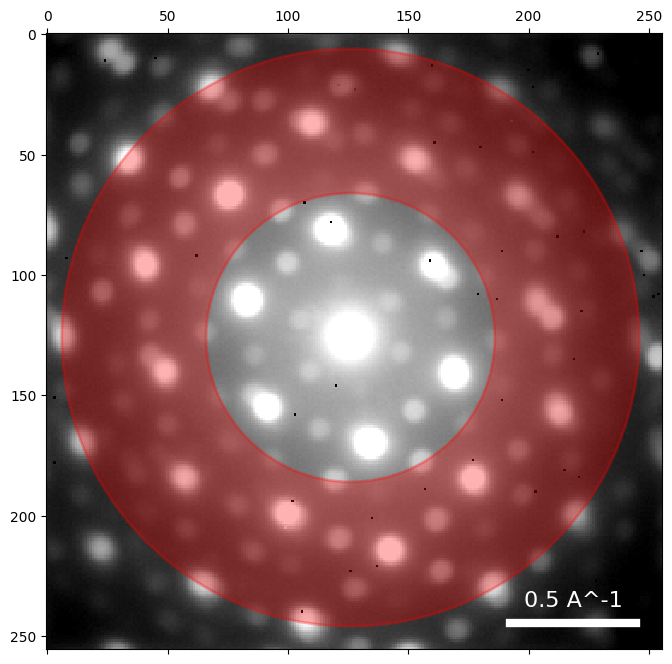

100%|██████████| 19100/19100 [00:01<00:00, 14095.24it/s]


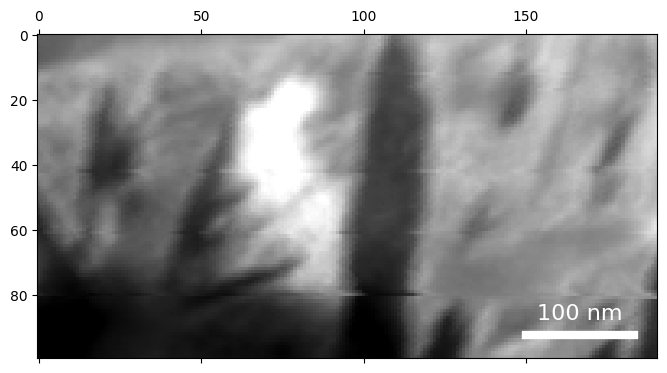

In [10]:
# Create an annular dark field (ADF) virtual detector using user-chosen values:
center = (126,126)
radii = (60,120)

# Plot the ADF detector
ax2 = py4DSTEM.visualize.show(
    dataset.tree['dp_mean'], 
    scaling='log',
    annulus = {
      'center':center,
      'radii':radii,
      'alpha':0.3,
      'fill':True,
    
    }
)
# Calculate the ADF image
dataset.get_virtual_image(
    mode = 'annulus',
    geometry = (center,radii),
    name = 'dark_field',
)

# Plot the ADF image
py4DSTEM.visualize.show(dataset.tree['dark_field'])

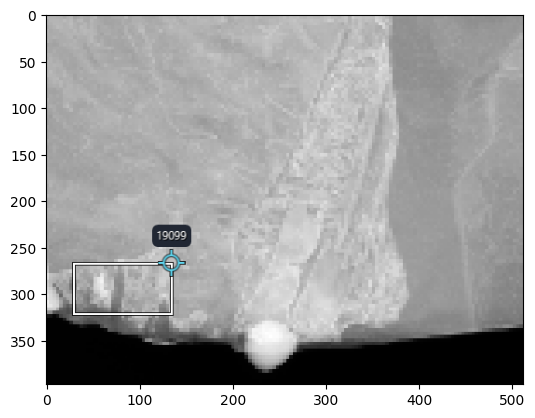

In [11]:
# Crop the survey image a bit
imga = img.crop((0, 65, 512, 462))
plt.imshow(imga)

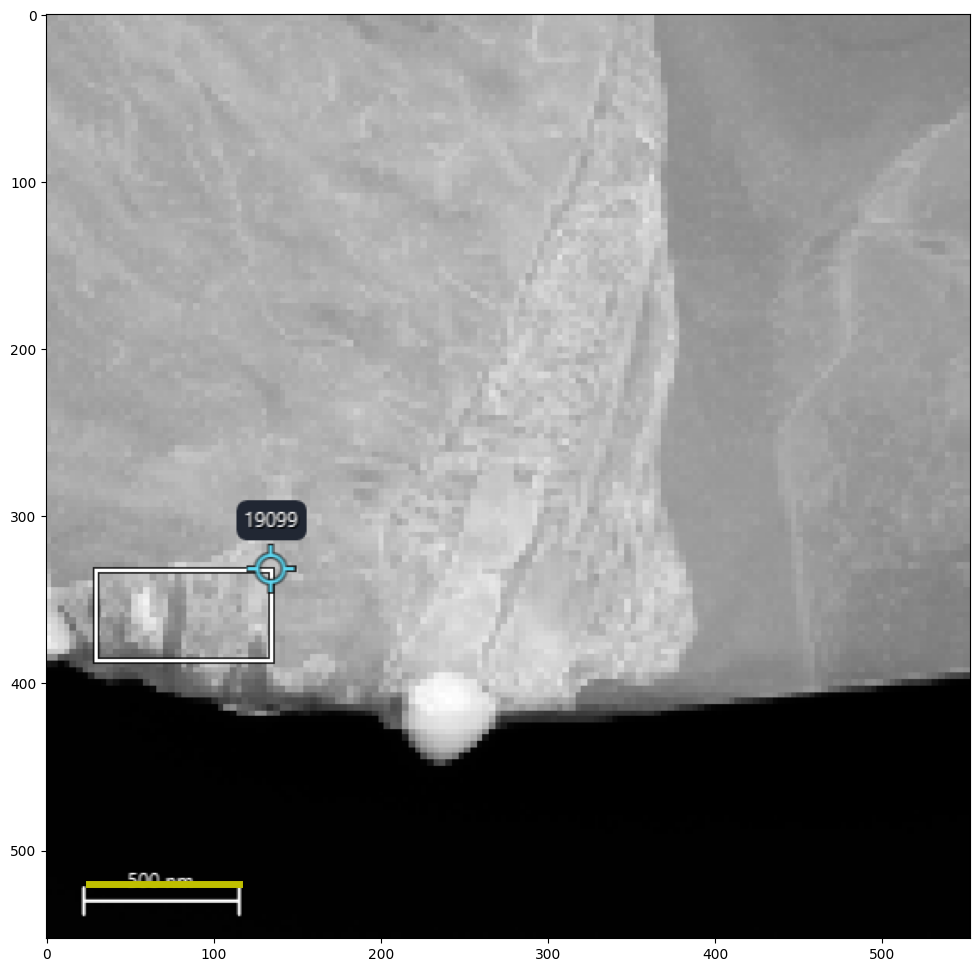

In [12]:
# Check the size for the scalebar
fig = plt.figure(figsize=(16,12))
plt.imshow(img)
plt.plot([25,115],[520,520], lw=5, c='y')

100%|██████████| 199/199 [00:02<00:00, 80.56it/s]
/local/environments/py4dstem_latest/py4dstem_latest-venv/lib64/python3.8/site-packages/py4DSTEM/visualize/show.py:302: UserWarning: Warning, min/max are deprecated and will not be supported in a future version. Use vmin/vmax instead.
  warnings.warn("Warning, min/max are deprecated and will not be supported in a future version. Use vmin/vmax instead.")
/local/environments/py4dstem_latest/py4dstem_latest-venv/lib64/python3.8/site-packages/py4DSTEM/visualize/show.py:304: UserWarning: Warning, clipvals is deprecated and will not be supported in a future version. Use intensity_range instead.
  warnings.warn("Warning, clipvals is deprecated and will not be supported in a future version. Use intensity_range instead.")


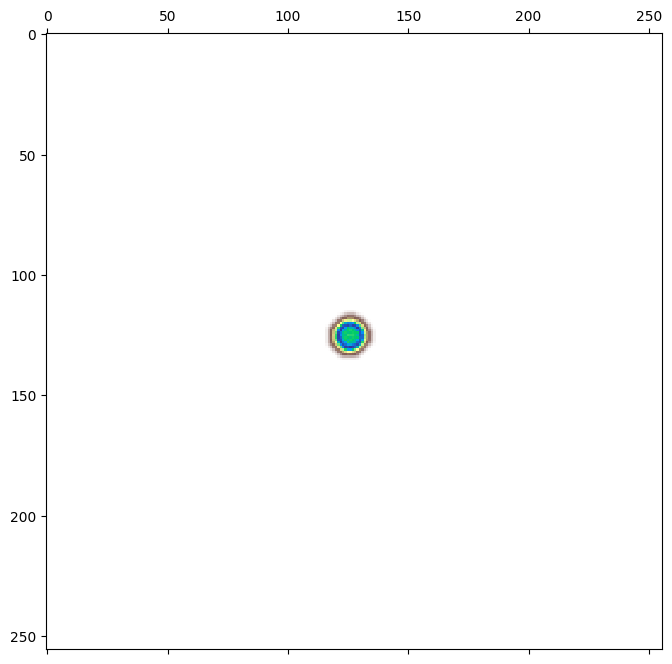

In [13]:
# Make an average probe for detecting the discs
probenew = py4DSTEM.process.probe.get_probe_from_4Dscan_ROI_lims(
    dataset,
    (60,70,0,20),
    mask_threshold=0.50,
    mask_expansion=4,
    mask_opening=2,
    verbose=False,
    align=True,
    )
py4DSTEM.visualize.show(
    probenew,
    figsize=(8,8),
    cmap='terrain_r',
    clipvals='manual',min=0,max=1000
)

/local/environments/py4dstem_latest/py4dstem_latest-venv/lib64/python3.8/site-packages/py4DSTEM/visualize/show.py:304: UserWarning: Warning, clipvals is deprecated and will not be supported in a future version. Use intensity_range instead.
  warnings.warn("Warning, clipvals is deprecated and will not be supported in a future version. Use intensity_range instead.")


Estimated probe radius = 6.66 pixels
125.34489069470384 125.83865803701092


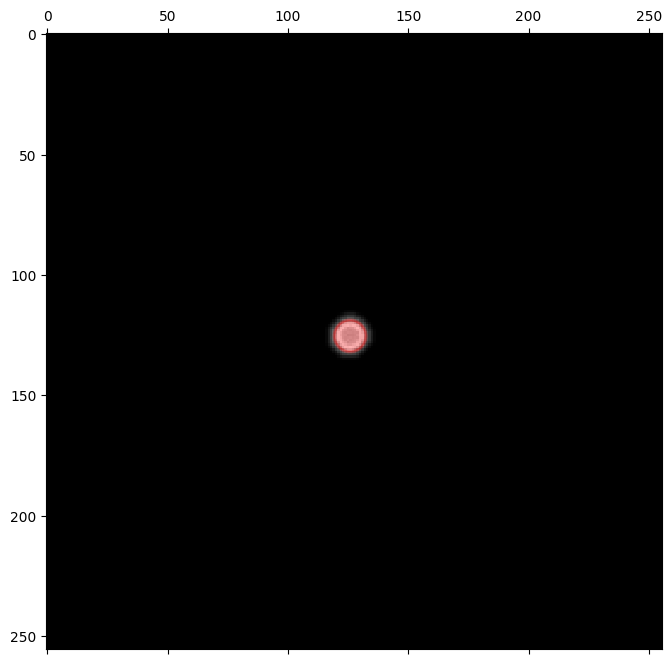

In [14]:
# Estimate the semiangle (radius) of the probe, and the center coordinates.
# Note that we need to lower the thresholds to make the get_probe_size() function work with a bullseye probe.

probe_semiangle, probe_qx0, probe_qy0 = py4DSTEM.process.calibration.get_probe_size(
    probenew,
    thresh_lower = 0.1,
    thresh_upper = 1,
)

# plot the mean diffraction pattern, with the estimated probe radius overlaid as a circle
fig, ax = py4DSTEM.visualize.show_circles(
    probenew, 
    (probe_qx0, probe_qy0), 
    probe_semiangle,
    clipvals='manual',
    vmin=0,
    vmax=3000, 
    returnfig=True,
)

# uncomment these lines to zoom in
#ax.set_xlim([100, 150])
#ax.set_ylim([100, 150])

# Print the estimate probe radius
print('Estimated probe radius =', '%.2f' % probe_semiangle, 'pixels')
print(probe_qx0, probe_qy0)

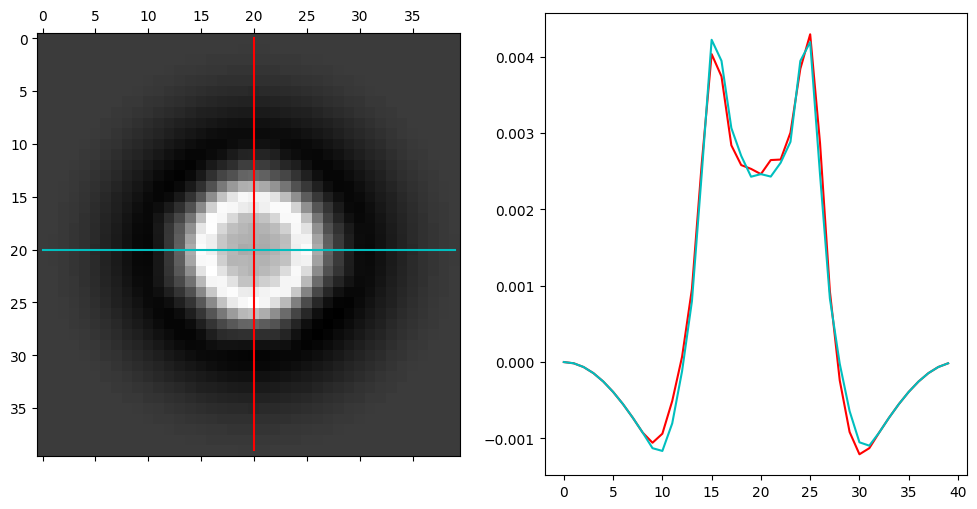

In [15]:
# Construct a probe template to use as a kernel for correlation disk detection

probe_kernel = py4DSTEM.process.probe.get_probe_kernel_edge_sigmoid(
    probenew,
    (probe_semiangle * 0.0, probe_semiangle * 3.0),
#     bilinear=True,
)

# Plot the probe kernel
py4DSTEM.visualize.show_kernel(
    probe_kernel, 
    R=20, 
    L=20, 
    W=1)

/local/environments/py4dstem_latest/py4dstem_latest-venv/lib64/python3.8/site-packages/matplotlib/cbook/__init__.py:1096: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)
/local/environments/py4dstem_latest/py4dstem_latest-venv/lib64/python3.8/site-packages/matplotlib/cbook/__init__.py:1096: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


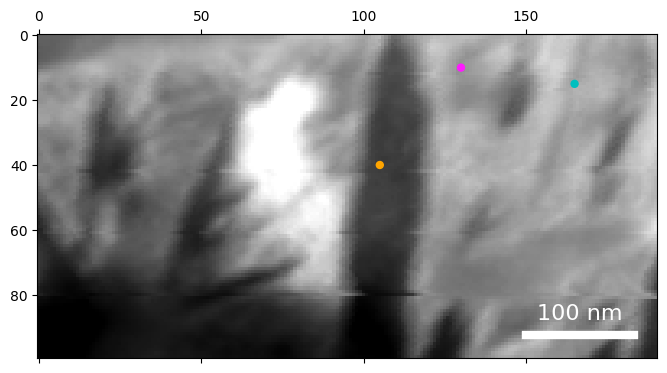

/local/environments/py4dstem_latest/py4dstem_latest-venv/lib64/python3.8/site-packages/py4DSTEM/visualize/show.py:304: UserWarning: Warning, clipvals is deprecated and will not be supported in a future version. Use intensity_range instead.
  warnings.warn("Warning, clipvals is deprecated and will not be supported in a future version. Use intensity_range instead.")
/local/environments/py4dstem_latest/py4dstem_latest-venv/lib64/python3.8/site-packages/py4DSTEM/visualize/show.py:304: UserWarning: Warning, clipvals is deprecated and will not be supported in a future version. Use intensity_range instead.
  warnings.warn("Warning, clipvals is deprecated and will not be supported in a future version. Use intensity_range instead.")
/local/environments/py4dstem_latest/py4dstem_latest-venv/lib64/python3.8/site-packages/py4DSTEM/visualize/show.py:304: UserWarning: Warning, clipvals is deprecated and will not be supported in a future version. Use intensity_range instead.
  warnings.warn("Warning, 

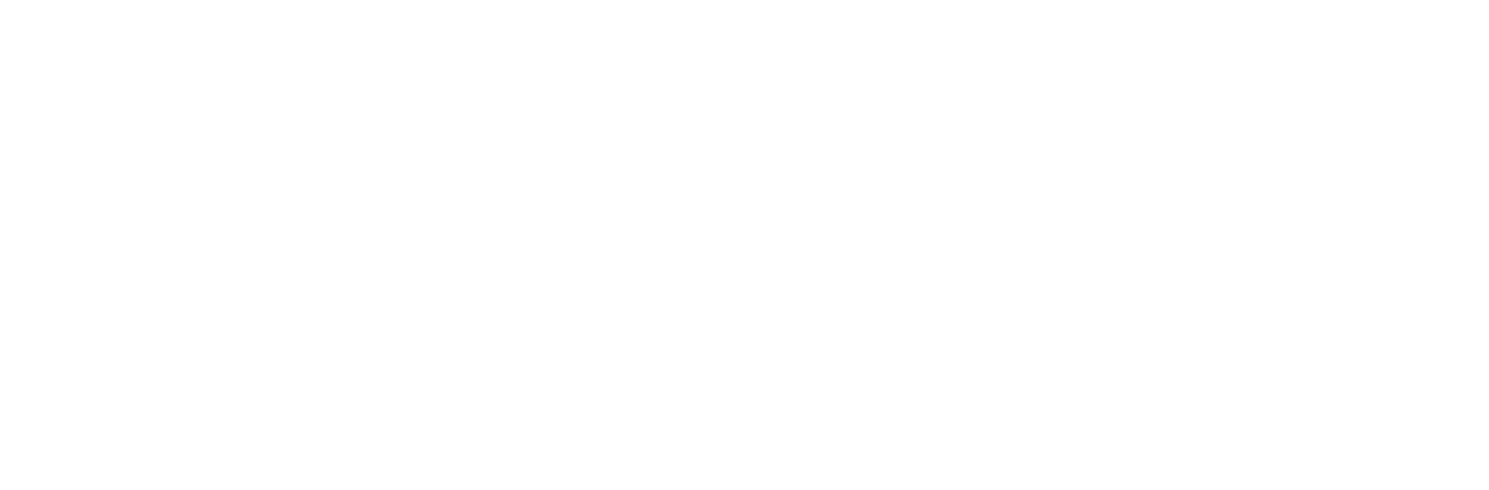

In [16]:
# Test hyperparameters on a few probe positions
# Visualize the diffraction patterns and the located disk positions

rys = 130, 165,105
rxs = 10, 15,40
colors=[(1,0.1,1),'c','orange']
py4DSTEM.visualize.show(
    dataset.tree['dark_field'],
    points = {
        'x': rxs,
        'y': rys,
        'pointcolor': colors
    },
)

# Hyperparameters
detect_params = {
    'corrPower': 1.0,
    'sigma': 0,
    'edgeBoundary': 8,
    'minRelativeIntensity': 0,
    'minAbsoluteIntensity': 3,
    'minPeakSpacing': 12,
    'subpixel' : 'poly',
    'upsample_factor': 8,
    'maxNumPeaks': 1000,
}

disks_selected = dataset.find_Bragg_disks(
    data = (rxs, rys),
    template = probe_kernel,
    **detect_params,
)

py4DSTEM.visualize.show_image_grid(
    get_ar = lambda i:dataset.data[rxs[i],rys[i],:,:],
    H=1, 
    W=3,
    axsize=(5,5),
    clipvals='manual',
    vmin=5,
    vmax=500,
    scaling='power',
    power=0.5,
    get_bordercolor = lambda i:colors[i],
    get_x = lambda i: disks_selected[i].data['qx'],
    get_y = lambda i: disks_selected[i].data['qy'],
    get_pointcolors = lambda i: colors[i],
    open_circles = True,
    scale = 700,
)

In [17]:
rcup = {
    'font.size':28,
    'text.color':'w'
}
plt.rcParams.update(rcup)

/local/environments/py4dstem_latest/py4dstem_latest-venv/lib64/python3.8/site-packages/matplotlib/cbook/__init__.py:1096: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)
/local/environments/py4dstem_latest/py4dstem_latest-venv/lib64/python3.8/site-packages/matplotlib/cbook/__init__.py:1096: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


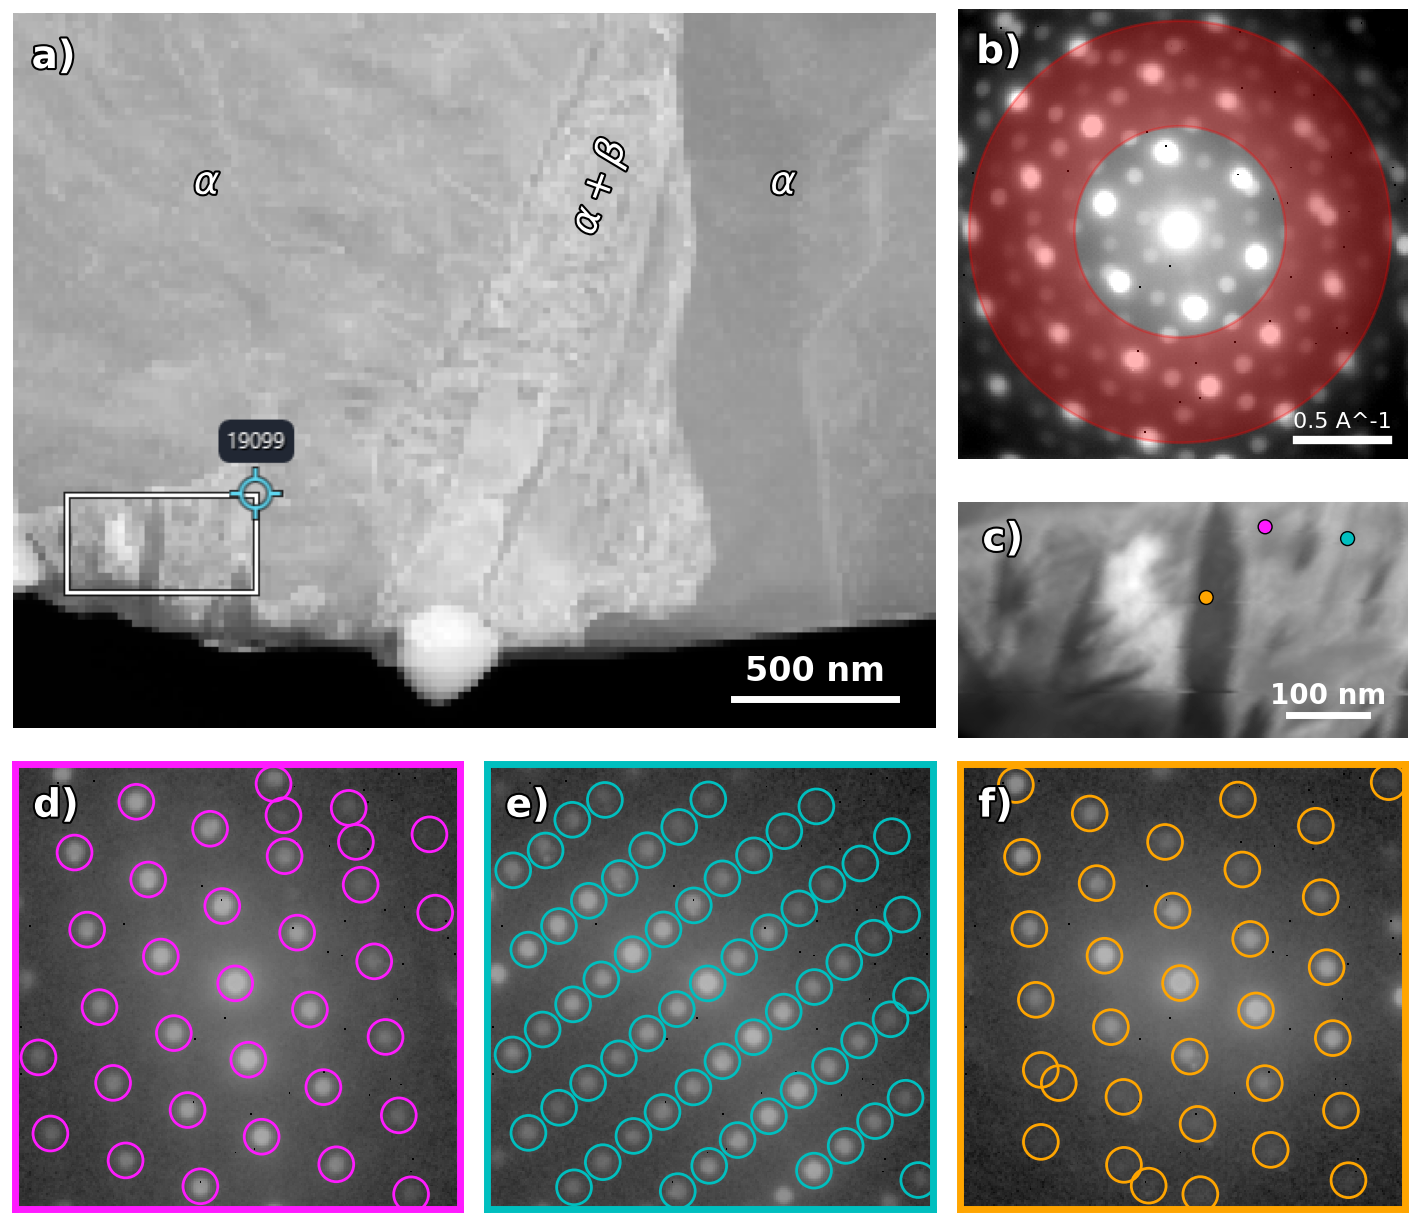

In [18]:
fig = plt.figure(figsize=(18,15.8))
figname = 'Figure1.png'
hr = [1,1,1.1,1.9]
gs = gridspec.GridSpec(4, 3, figure=fig, wspace=0.05, hspace=0.05, height_ratios = hr)
axa = plt.subplot(gs[0:3,0:2])
axa.imshow(imga)
x,y,w=400,380,90
axa.plot([x,x+w],[y,y], lw=5, c='w')
axa.text(x+w/2,y-10,'500 nm', horizontalalignment='center', fontsize=24, c='w', fontweight='bold')
axa.set_axis_off()
texta = axa.text(10,30,'a)', fontweight='bold')
texta.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'),
                       path_effects.Normal()])
labela1 = axa.text(100,100,r'$\alpha$', fontweight='bold')
labela1.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'),
                       path_effects.Normal()])
labela2 = axa.text(305,120,r'$\alpha+\beta$', fontweight='bold', rotation=70)
labela2.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'),
                       path_effects.Normal()])
labela3 = axa.text(420,100,r'$\alpha$', fontweight='bold')
labela3.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'),
                       path_effects.Normal()])

axb = plt.subplot(gs[0:2,2])
py4DSTEM.visualize.show(
    dataset.tree['dp_mean'], 
    scaling='log',
    annulus = {
      'center':center,
      'radii':radii,
      'alpha':0.3,
      'fill':True,
    },
    figax=(fig,axb)
)
axb.set_axis_off()
textb = axb.text(10,30,'b)', fontweight='bold', c='w')
textb.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'),
                       path_effects.Normal()])

axc = plt.subplot(gs[2,2])
axc.imshow(dataset.tree['dark_field'].data, cmap='gray')
barx, bary, lengthnm =140,90,100
axc.plot([barx,barx+lengthnm/step],[bary,bary],lw=5,c='w')
axc.text(barx+lengthnm/step/2, bary-5, str(lengthnm)+' nm', horizontalalignment='center',
        color='w', fontsize=20, fontweight='bold')
axc.scatter(rys, rxs, color=colors[:3], s=100, ec='k')
axc.set_axis_off()
textc = axc.text(10,20,'c)', fontweight='bold')
textc.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'),
                       path_effects.Normal()])

labels = ['d', 'e', 'f'] 
for i in range(3):
    axd = plt.subplot(gs[3,i])
    py4DSTEM.visualize.show(
        dataset.data[rxs[i],rys[i],:,:], 
        scaling='log',
        bordercolor = colors[i],
        figax=(fig,axd), 
        intensity_range='absolute',
        vmin=1,
        vmax=12
    )
    plist = disks_selected[i].data
    ec = colors[i]
    for point in plist:
        circle = Circle((point[1], point[0]), radius=10, ec=ec, lw=2, fill=False)
        axd.add_patch(circle)
    axd.set_xticks([])
    axd.set_yticks([])
    textd = axd.text(10,30,labels[i]+')', fontweight='bold')
    textd.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'),
                       path_effects.Normal()])

#fig.savefig(filepath+figname, bbox_inches='tight')